In [20]:
# !conda install -c conda-forge umap-learn --yes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import timeit
# import umap

### taking data N dimensional samples

In [2]:
df = pd.read_csv('./EEG_data.csv')
data=pd.read_csv('./demographic_info.csv')

renaming the features for easy to use (like in original dataset have some unnecessary space) and joining the dataset 

In [3]:
data = data.rename(columns = {'subject ID': 'SubjectID',' gender':'gender',' age':'age',' ethnicity':'ethnicity'})
df = df.merge(data,how = 'inner',on = 'SubjectID')

In [4]:
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M


replacing string values with integer values and dropping the meaningless features

In [5]:
df['gender']=df['gender'].replace({'M':1,'F':0})
df['ethnicity']=df['ethnicity'].replace({'Han Chinese':0,'Bengali':1,'English':2})
df.drop(columns = ['SubjectID','VideoID','predefinedlabel'],inplace=True)

defining the target

In [6]:
target=df['user-definedlabeln']

<Axes: title={'center': 'Correlation with Target'}>

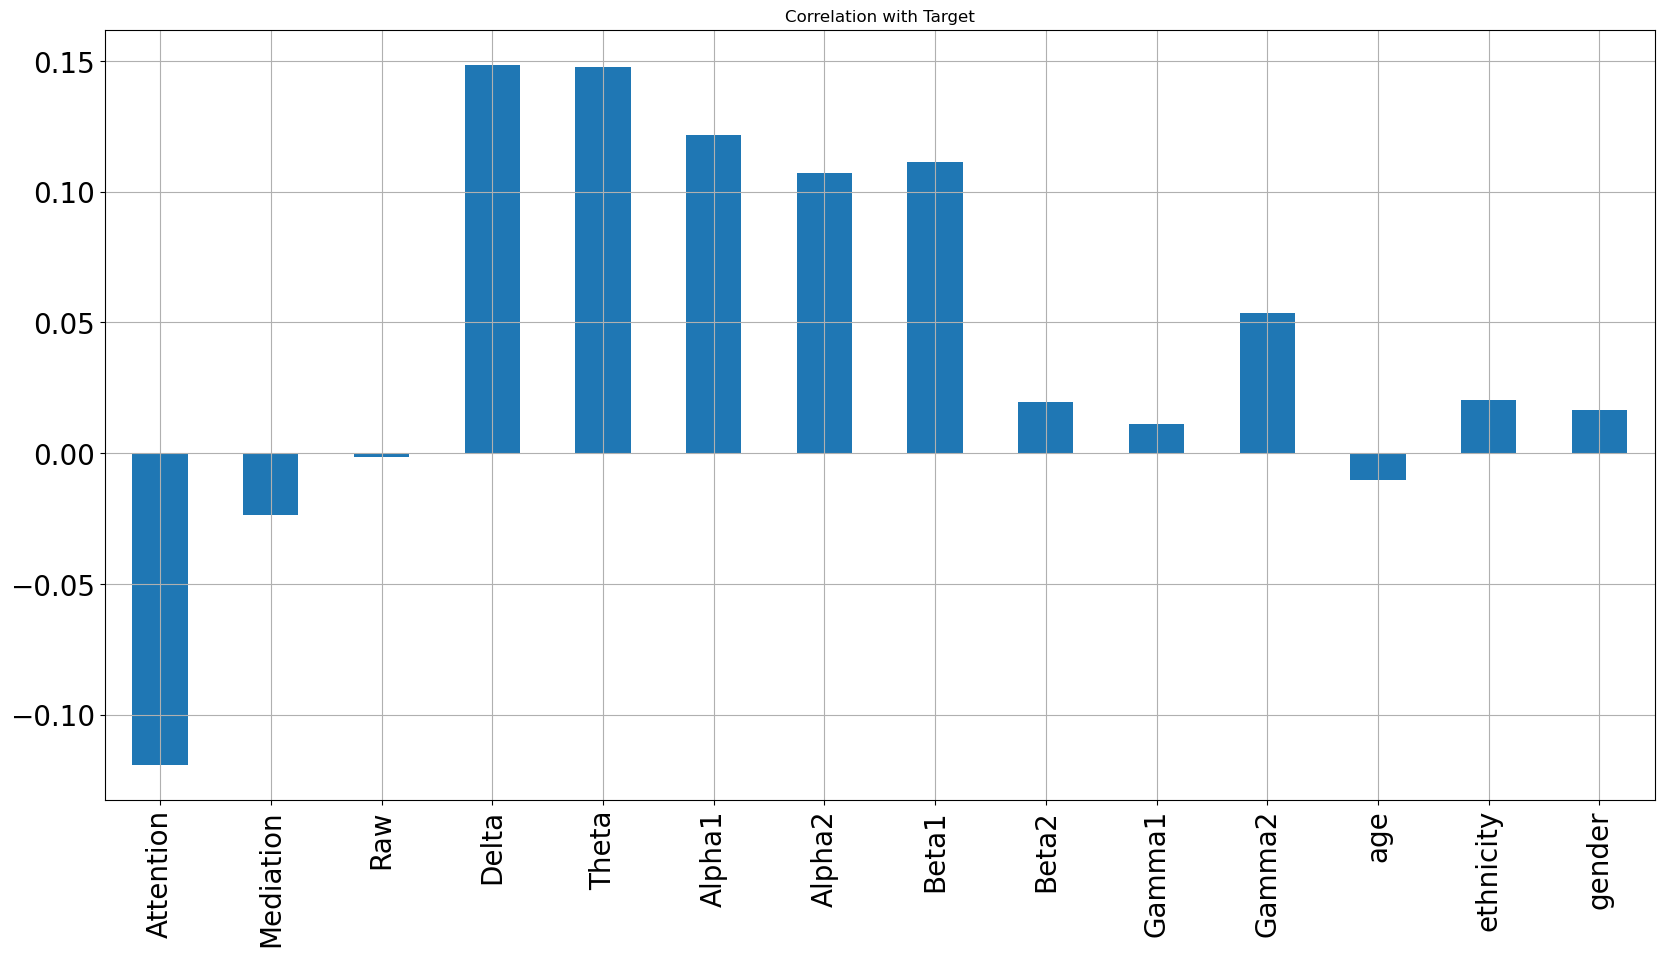

In [7]:
X=df.drop(['user-definedlabeln'],axis=1)
X.corrwith(df['user-definedlabeln']).plot.bar(
        figsize = (20, 10), title = "Correlation with Target", fontsize = 20,
        rot = 90, grid = True)

Referred from : https://www.geeksforgeeks.org/principal-component-analysis-pca/

### Dimensionality reduction using PCA

In [8]:
# Mean
X_mean = X.mean()

# Standard deviation
X_std = X.std()

# Standardization
Z = (X - X_mean) / X_std


In [9]:
Z.shape

(12811, 14)

The covariance matrix helps us visualize how strong the dependency of two features is with each other in the feature space.

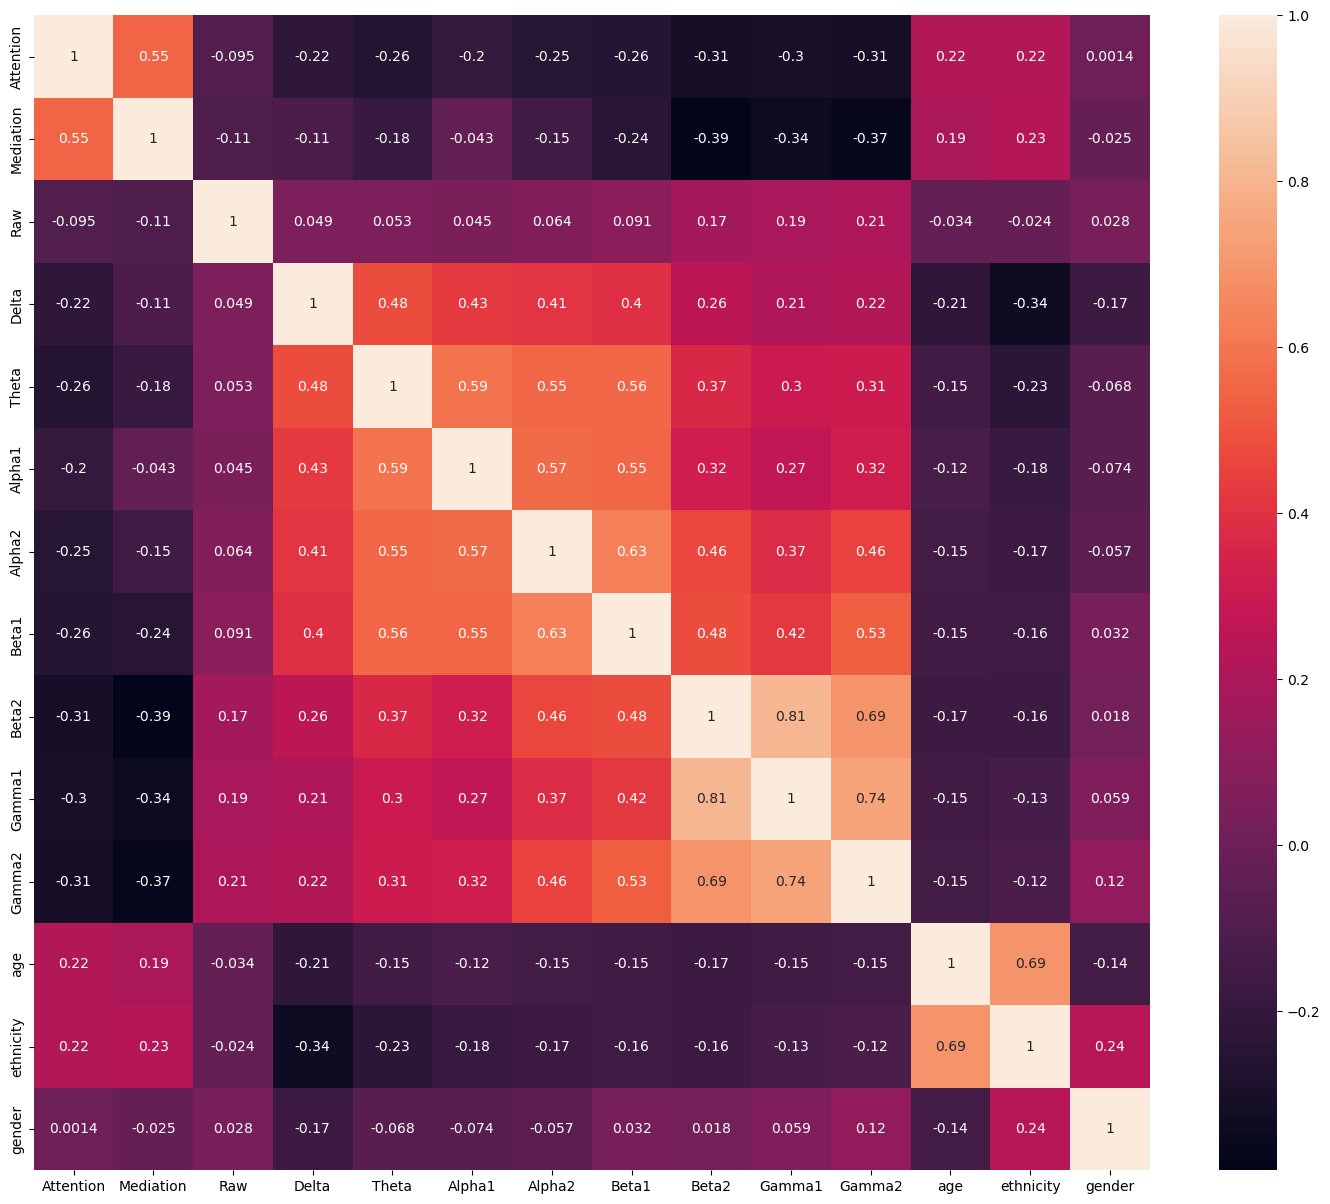

In [10]:
c = Z.cov()
 
# Plot the covariance matrix
plt.figure(figsize=(18,15))
sns.heatmap(c,annot=True)
plt.show()

Now we will compute the `eigenvectors` and `eigenvalues` for our feature space which serve a great purpose in identifying the principal components for our feature space.

In [11]:
eigenvalues, eigenvectors = np.linalg.eig(c)
print('Eigen values:\n', eigenvalues)
print('Eigen values Shape:', eigenvalues.shape)
print('Eigen Vector Shape:', eigenvectors.shape)

Eigen values:
 [4.7682621  1.74196905 1.62883445 1.07333627 0.98162116 0.8992218
 0.16852763 0.20789281 0.28328842 0.34628998 0.39166226 0.47508206
 0.4552567  0.57875531]
Eigen values Shape: (14,)
Eigen Vector Shape: (14, 14)


In [12]:
# Index the eigenvalues in descending order 
idx = eigenvalues.argsort()[::-1]

# Sort the eigenvalues in descending order 
eigenvalues = eigenvalues[idx]

# sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:,idx]


In [13]:
eigenvalues

array([4.7682621 , 1.74196905, 1.62883445, 1.07333627, 0.98162116,
       0.8992218 , 0.57875531, 0.47508206, 0.4552567 , 0.39166226,
       0.34628998, 0.28328842, 0.20789281, 0.16852763])

In [14]:
explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)
explained_var

array([0.34059015, 0.46501651, 0.58136183, 0.65802871, 0.7281445 ,
       0.79237463, 0.8337143 , 0.86764873, 0.90016706, 0.92814294,
       0.95287794, 0.97311283, 0.98796231, 1.        ])

#### Determine the Number of Principal Components 
Here we can either consider the number of principal components of any value of our choice or by limiting the explained variance. Here I am considering explained variance more than equal to 50%. Let’s check how many principal components come into this.

In [15]:
n_components = np.argmax(explained_var >= 0.5) + 1
n_components

3

##### Project the Data onto the Selected Principal Components

- Find the projection matrix, It is a matrix of eigenvectors corresponding to the largest eigenvalues of the covariance matrix of the data. it projects the high-dimensional dataset onto a lower-dimensional subspace.
- The eigenvectors of the covariance matrix of the data are referred to as the principal axes of the data, and the projection of the data instances onto these principal axes are called the principal components. 

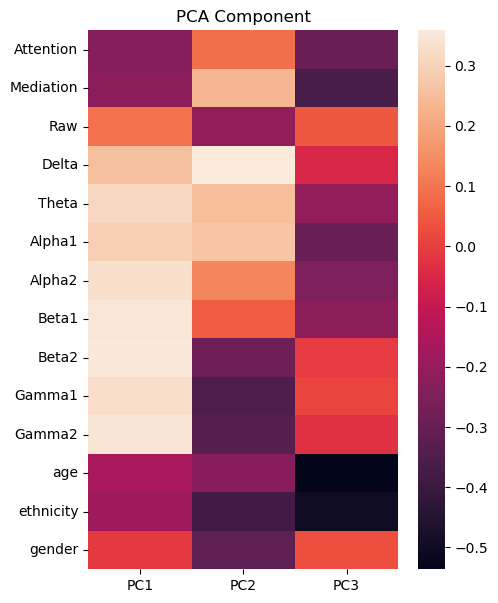

In [27]:
# PCA component or unit matrix
u = eigenvectors[:,:n_components]
pca_component = pd.DataFrame(u,
							index = X.columns,
							columns=['PC{}'.
							format(i+1)
							for i in range(n_components)]
							)

# plotting heatmap
plt.figure(figsize =(5, 7))
sns.heatmap(pca_component)
plt.title('PCA Component')
plt.show()
# print(pca_component)

### PCA using Using Sklearn

In [26]:
# Let's say, components = 5
pca = PCA(n_components=3)

x_pca = pca.fit_transform(Z)

# Create the dataframe
df_pca1 = pd.DataFrame(x_pca,
					columns=['PC{}'.
					format(i+1)
						for i in range(n_components)])
print(df_pca1)

            PC1       PC2       PC3
0     -0.249167  0.279113 -0.391961
1     -1.066147  0.381447 -1.138785
2      1.936326 -0.500621  0.778208
3      0.711335 -0.621826 -0.079762
4      1.387595 -0.284445  0.328912
...         ...       ...       ...
12806 -0.986209 -0.590526 -0.884249
12807  4.368058 -0.279776  1.124156
12808 -0.162822 -1.227508 -0.611268
12809 -0.904351 -0.741998 -1.063296
12810  3.787148 -1.127624  0.754570

[12811 rows x 3 columns]


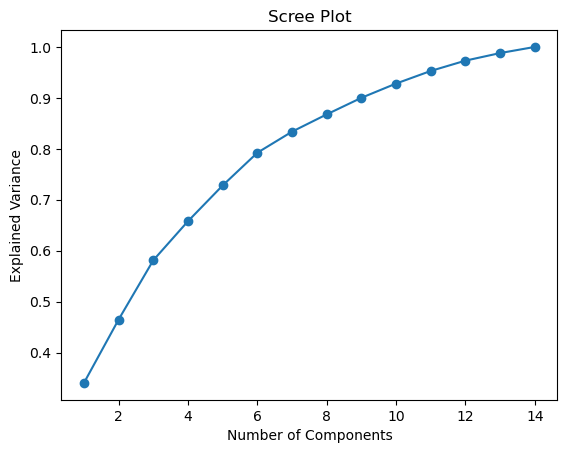

In [29]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.show()

In [30]:
scaler = StandardScaler()
X=scaler.fit_transform(df_pca1)

### Division the dataset into training and testing set

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
y=df['user-definedlabeln']
X_train,x_test,Y_train,y_test=train_test_split(X,y,random_state=108,test_size=0.27)

### ML algorithm SVM

In [34]:
from sklearn.svm import SVC

In [35]:
svm_classifier = SVC(random_state=108)

# Train the classifier on the training data
svm_classifier.fit(X_train, Y_train)

SVC(random_state=108)

### Trained classification model `svm_classifier`

In [41]:
predictions = svm_classifier.predict(x_test).astype(int)
predictions

array([0, 0, 1, ..., 0, 0, 0])

### accuracy of the model

In [44]:
from sklearn.metrics import precision_score,recall_score, f1_score, accuracy_score,confusion_matrix

In [42]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.6299508528476438

### performance evaluation of the model

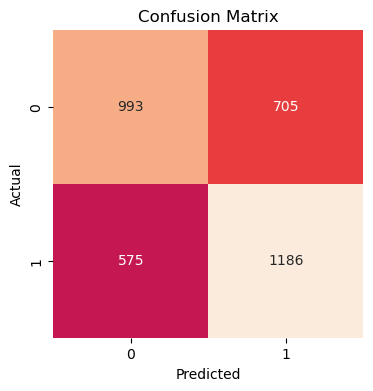

In [45]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 4))

sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

TP = True Positive<br>
TN = True Negative<br>
FP = False Positive<br>
FN = False Negative<br>

$ Precision = \frac{TP}{TP + FP} $<br>

$ Recall = \frac{TP}{TP + FN} $ <br>

$ F1 score = \frac{2×Precision×Recall}{Precision+Recall} $

In [48]:
print("Precision:", precision_score(y_test,predictions,average="weighted")) 
  
print('Recall:', recall_score(y_test,predictions,average="weighted"))

print('F1 score:', f1_score(y_test, predictions, average="weighted"))

Precision: 0.6301804642978052
Recall: 0.6299508528476438
F1 score: 0.6291724343999804


All dimensions pca svm

In [30]:
for i in range(1,15):
	k=i
	pca = PCA(n_components=k)

	x_pca = pca.fit_transform(Z)

	# Create the dataframe
	df_pca1 = pd.DataFrame(x_pca,
						columns=['PC{}'.
						format(i+1)
							for i in range(k)])

	scaler = StandardScaler()
	X=scaler.fit_transform(df_pca1)

	y=df['user-definedlabeln']
	X_train,x_test,Y_train,y_test=train_test_split(X,y,random_state=108,test_size=0.27)
	start = timeit.default_timer()
	svm_classifier = SVC()

	# Train the classifier on the training data
	svm_classifier.fit(X_train, Y_train)

	predictions = svm_classifier.predict(x_test).astype(int)

	accuracy = accuracy_score(y_test, predictions)

	stop = timeit.default_timer()

	print("for k = ", k, "Accuracy is: ", accuracy, "Time taken: ", stop-start)

for k =  1 Accuracy is:  0.5831165076611737 Time taken:  5.015151202999732
for k =  2 Accuracy is:  0.5987279560566637 Time taken:  4.557703698000296
for k =  3 Accuracy is:  0.6299508528476438 Time taken:  5.238954172000376
for k =  4 Accuracy is:  0.646718704827985 Time taken:  4.912843232999876
for k =  5 Accuracy is:  0.6472969066204105 Time taken:  4.261937362000026
for k =  6 Accuracy is:  0.6446949985544955 Time taken:  4.339532183000301
for k =  7 Accuracy is:  0.6513443191673894 Time taken:  4.838742934000038
for k =  8 Accuracy is:  0.657126337091645 Time taken:  3.8859878549992573
for k =  9 Accuracy is:  0.6562590344030067 Time taken:  4.189654399000574
for k =  10 Accuracy is:  0.6588609424689217 Time taken:  4.006543560999489
for k =  11 Accuracy is:  0.6585718415727089 Time taken:  4.328491626999494
for k =  12 Accuracy is:  0.6631974559121133 Time taken:  4.842284476000714
for k =  13 Accuracy is:  0.6669557675628794 Time taken:  4.853314625999701
for k =  14 Accuracy i

### using keras

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks,layers

2024-01-22 00:09:06.418370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
inputs = keras.Input(shape=(X_train.shape[1]))
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model=keras.Model(inputs,outputs)
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy',keras.metrics.AUC(name='auc')]
             )
batch_size=32
epochs=50
history=model.fit(
            X_train,
            Y_train,
            validation_split=0.2,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[callbacks.ReduceLROnPlateau()]
)

2024-01-22 00:09:24.474662: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/50
234/234 [==============================] - 3s 11ms/step - loss: 0.6744 - accuracy: 0.5803 - auc: 0.6095 - val_loss: 0.6739 - val_accuracy: 0.5831 - val_auc: 0.6085 - lr: 0.0010
Epoch 2/50
234/234 [==============================] - 4s 17ms/step - loss: 0.6659 - accuracy: 0.6014 - auc: 0.6295 - val_loss: 0.6685 - val_accuracy: 0.5852 - val_auc: 0.6345 - lr: 0.0010
Epoch 3/50
234/234 [==============================] - 2s 10ms/step - loss: 0.6640 - accuracy: 0.6019 - auc: 0.6332 - val_loss: 0.6741 - val_accuracy: 0.5612 - val_auc: 0.6305 - lr: 0.0010
Epoch 4/50
234/234 [==============================] - 2s 11ms/step - loss: 0.6617 - accuracy: 0.6059 - auc: 0.6402 - val_loss: 0.6684 - val_accuracy: 0.6221 - val_auc: 0.6412 - lr: 0.0010
Epoch 5/50
234/234 [==============================] - 6s 27ms/step - loss: 0.6595 - accuracy: 0.6093 - auc: 0.6445 - val_loss: 0.6637 - val_accuracy: 0.6098 - val_auc: 0.6457 - lr: 0.0010
Epoch 6/50
234/234 [==============================] - 2s 9ms

In [51]:
model.evaluate(x_test,y_test)

109/109 [==============================] - 1s 9ms/step - loss: 0.6415 - accuracy: 0.6297 - auc: 0.6855


[0.6415386199951172, 0.6296617388725281, 0.6855443716049194]

In [52]:
y_true = np.array(y_test)

y_pred = np.squeeze(model.predict(x_test))
y_pred = np.array(y_pred >=0.5, dtype=np.int)
y_pred

109/109 [==============================] - 1s 6ms/step


/tmp/ipykernel_9971/295032384.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.array(y_pred >=0.5, dtype=np.int)


array([1, 1, 1, ..., 0, 0, 1])

In [53]:
accuracyKeras=accuracy_score(y_true, y_pred)
accuracyKeras

0.629661751951431

In [55]:
print("Precision:", precision_score(y_test, 
                                    y_pred, 
                                    average="weighted"))
  
print('Recall:', recall_score(y_test, 
                              y_pred, 
                              average="weighted"))

print('F1 score:', f1_score(y_test, y_pred, 
                            average="weighted"))

Precision: 0.6354289253956336
Recall: 0.629661751951431
F1 score: 0.62379705215779


In [ ]:
for i in range(1,15):
	k=i
	pca = PCA(n_components=k)

	x_pca = pca.fit_transform(Z)

	# Create the dataframe
	df_pca1 = pd.DataFrame(x_pca,
						columns=['PC{}'.
						format(i+1)
							for i in range(k)])

	scaler = StandardScaler()
	X=scaler.fit_transform(df_pca1)

	y=df['user-definedlabeln']
	X_train,x_test,Y_train,y_test=train_test_split(X,y,random_state=108,test_size=0.27)
	
	inputs = tf.keras.Input(shape=(X_train.shape[1]))
	x = layers.Dense(256, activation='relu')(inputs)
	x = layers.Dense(256, activation='relu')(x)
	outputs = layers.Dense(1, activation='sigmoid')(x)

	model=keras.Model(inputs,outputs)
	model.compile(optimizer='adam',
				loss='binary_crossentropy',
				metrics=['accuracy',keras.metrics.AUC(name='auc')]
				)
	batch_size=32
	epochs=50
	history=model.fit(
				X_train,
				Y_train,
				validation_split=0.2,
				batch_size=batch_size,
				epochs=epochs,
				callbacks=[callbacks.ReduceLROnPlateau()]
	)
	start = timeit.default_timer()
	model.evaluate(x_test,y_test)

	y_true = np.array(y_test)
	y_pred = np.squeeze(model.predict(x_test))
	y_pred = np.array(y_pred >=0.5, dtype=np.int)

	accuracyKeras=accuracy_score(y_true, y_pred)
	stop = timeit.default_timer()

	print("for k = ",k,"accuracy keras is: ",accuracyKeras,"time taken is: ",stop-start)